In [1]:
import numpy as np
import matplotlib.pyplot as plt

In [2]:
import dendrotweaks as dd

/home/roman/Documents/code/DendroTweaks/app/src


In [3]:
swcm = dd.file_managers.SWCManager()
swcm.path_to_data = 'data/'

In [4]:
file_name = 'final_figure_extra-000.swc'
swcm.read(file_name)

Once the file is read we can view it's content as a Pandas DataFrame using `df` attribute. We can use functionality of pandas to perform EDA on the data. For example, we can see what types are present or the statistics for the coordinates.

In [5]:
swcm.df.type.value_counts()

3    1093
4     485
2      31
1       2
Name: type, dtype: int64

In [6]:
swcm.df[['x', 'y', 'z']].describe()

,x,y,z
count,1611.000000,1611.000000,1611.000000
mean,106.248401,89.774005,249.091248
std,45.194891,36.218604,92.210176
min,1.190749,0.396916,0.000000
25%,73.429511,64.300437,192.000000
50%,105.182814,87.718497,285.000000
75%,139.119155,114.311888,309.000000
max,202.427302,177.421576,375.000000


In [7]:
swcm.build_swc_tree()

Building SWC tree...
Connecting tree.


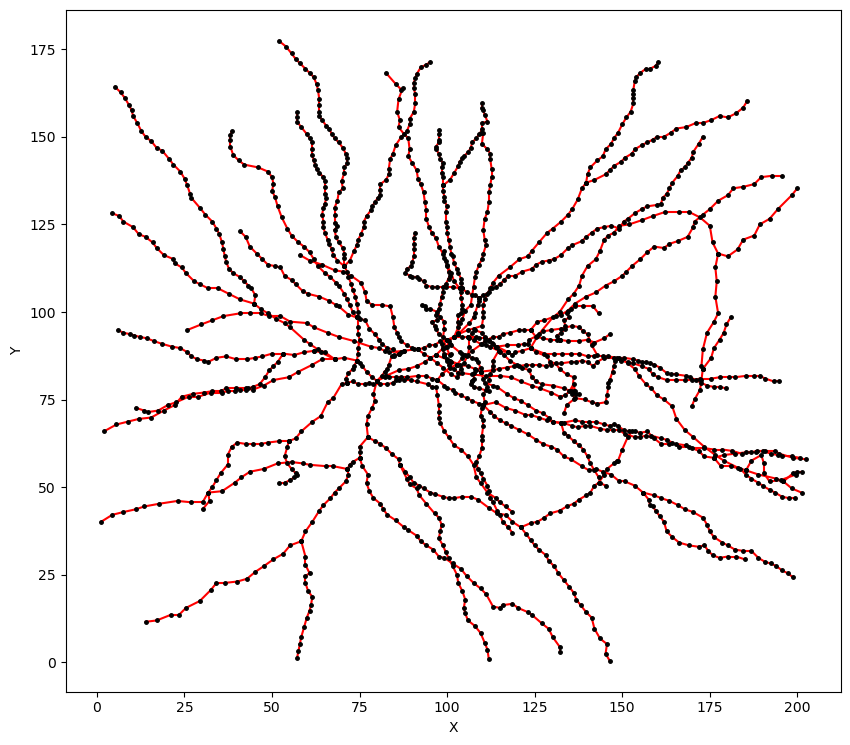

In [8]:
swcm.swc_tree.plot_points(projection='XY')

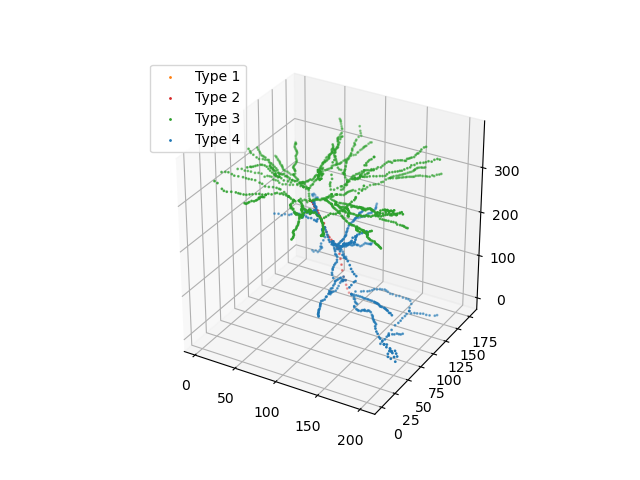

In [ ]:
%matplotlib widget
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d', aspect='equal')

# Get unique types and assign colors
types_to_colors = {1: 'C1', 2:'C3', 3: 'C2', 4: 'C0'}

# Plot each type with a different color
for t, color in types_to_colors.items():
    mask = swcm.df['type'] == t
    ax.scatter(swcm.df[mask]['x'], swcm.df[mask]['y'], swcm.df[mask]['z'], c=color, s=1, label=f'Type {t}')

ax.legend()
plt.show()

In [10]:
swcm.validate_swc_tree()

SWC tree validation passed successfully
    is connected: 1
    is sorted:    0
    is sectioned: 0
    is extended:  0


In [11]:
swcm.swc_tree.sort()

  Elapsed time: 0.0 seconds


In [13]:
swcm.swc_tree._nodes = sorted(swcm.swc_tree._nodes, key=lambda x: x.idx)

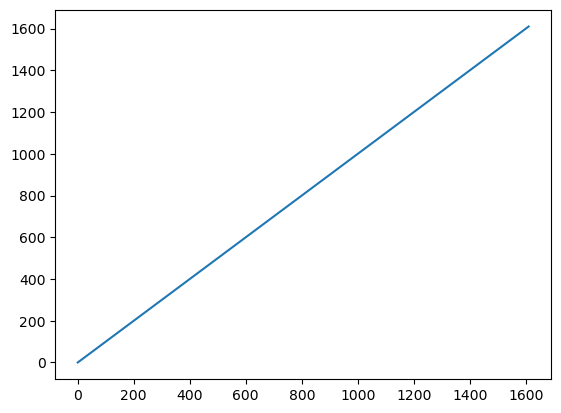

In [14]:
plt.figure()
plt.plot([node.idx for node in swcm.swc_tree._nodes])

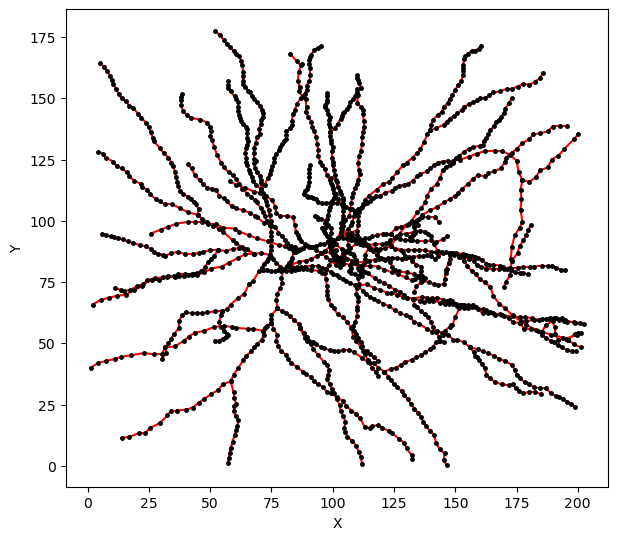

In [15]:
fig, ax = plt.subplots(figsize=(7, 7))
swcm.swc_tree.plot_points(ax, edges=True, annotate=True)

In [16]:
swcm.swc_tree.is_connected

True

In [11]:
# swcm.swc_tree.topology()

In [8]:
# swcm.swc_tree.detach_node(14)

In [9]:
# swcm.swc_tree.attach_node(14, 6)

In [10]:
# new_node = swcm.swc_tree._nodes[11].copy()
# print(new_node is swcm.swc_tree._nodes[11])
# print(new_node.idx == swcm.swc_tree._nodes[11].idx)
# swcm.swc_tree.insert_node(12, new_node)

In [17]:
swcm.postprocess_swc_tree(sort=True, split=True, shift=True, extend=True)

Postprocessing SWC tree...
  Sorting tree...
  Tree is already sorted.
Splitting tree to sections...
  Elapsed time: 0.0 seconds
Merging soma into a single section...
Shifting coordinates to soma center...
Extending tree...
SWC tree validation passed successfully
    is connected: 1
    is sorted:    1
    is sectioned: 1
    is extended:  1


In [18]:
swcm.swc_tree.soma_notation

'contour'

In [19]:
swcm.swc_tree.soma.pts3d[1].info();

Node 1:
  Type: soma
  Coordinates: (0.0, 0.0, 0.0)
  Radius: 0.0
  Parent: 0
  Section: 0


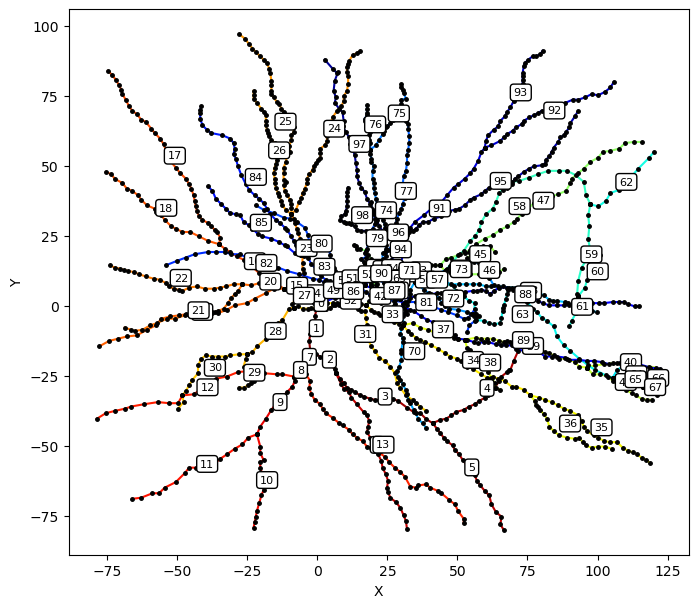

In [20]:
fig, ax = plt.subplots(figsize=(8, 8))
swcm.swc_tree.plot_sections_as_points(ax, 
                                      show_points=False, 
                                      show_lines=True, 
                                      annotate=True)
swcm.swc_tree.plot_points(ax, 
                          edges=False, 
                          annotate=True)

In [15]:
# swcm.swc_tree.rotate(90)

In [21]:
swcm.swc_tree.soma_center

array([0., 0., 0.])

In [22]:
swcm.build_sec_tree()

Building SEC tree...
Connecting tree.
SEC tree validation passed successfully.
    is connected: 1
    is sorted:    1


In [23]:
swcm.sec_tree.root.df_pts3d

,idx,type_idx,x,y,z,r,parent_idx
0,0,1.0,0.0,0.0,0.0,0.0,-1
0,1,1.0,0.0,0.0,0.0,0.0,0


In [24]:
swcm.sec_tree.topology()

parent |   idx
---------------
    -1 |   •0
     0 |   ├─•1
     1 |   │ ├─•2
     2 |   │ │ ├─•3
     3 |   │ │ │ ├─•4
     3 |   │ │ │ └─•5
     2 |   │ │ └─•6
     1 |   │ └─•7
     7 |   │   ├─•8
     8 |   │   │ ├─•9
     9 |   │   │ │ ├─•10
     9 |   │   │ │ └─•11
     8 |   │   │ └─•12
     7 |   │   └─•13
     0 |   ├─•14
    14 |   │ ├─•15
    15 |   │ │ ├─•16
    16 |   │ │ │ ├─•17
    16 |   │ │ │ └─•18
    15 |   │ │ ├─•19
    15 |   │ │ └─•20
    20 |   │ │   ├─•21
    20 |   │ │   └─•22
    14 |   │ ├─•23
    23 |   │ │ ├─•24
    23 |   │ │ ├─•25
    23 |   │ │ └─•26
    14 |   │ └─•27
    27 |   │   ├─•28
    28 |   │   │ ├─•29
    28 |   │   │ └─•30
    27 |   │   └─•31
     0 |   ├─•32
    32 |   │ ├─•33
    33 |   │ │ ├─•34
    34 |   │ │ │ ├─•35
    34 |   │ │ │ └─•36
    33 |   │ │ └─•37
    37 |   │ │   ├─•38
    37 |   │ │   └─•39
    39 |   │ │     ├─•40
    39 |   │ │     └─•41
    32 |   │ └─•42
    42 |   │   ├─•43
    43 |   │   │ ├─•44
    44 |   │   │ │ ├

array([[<Axes: title={'center': 'XZ'}>, <Axes: title={'center': 'YZ'}>],
       [<Axes: title={'center': 'XY'}>, <Axes: >]], dtype=object)

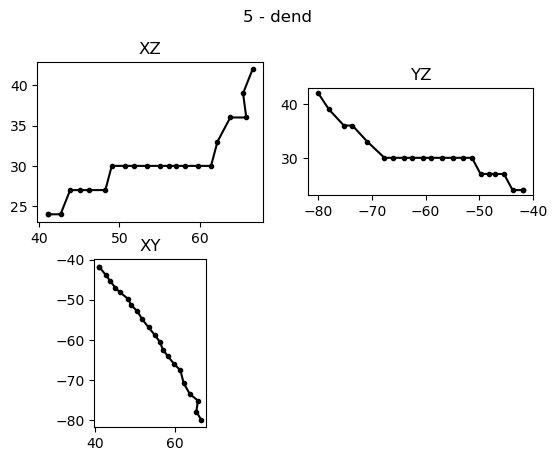

In [27]:
swcm.sec_tree.sections[5].plot_pts3d(plot_radii=False)